# Model training

#### Problem statement:
The marketing department selects a recipe each day to post on the homepage of the company's website. They have noticed that traffic to the rest of the website increases by as much as 40% if they pick a popular recipe. Since high traffic leads to more subscriptions to the company's services, they want to maximize traffic to their website.
Currently, they don't know how to determine whether a recipe will be popular, so they want a reliable solution that can select popular recipes at least 80% of the time.

- Since we have to focus on precision to detect as many high-traffic recipes as possible while keeping an eye on recall too to not miss out on too many high-traffic recipes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import dagshub
import warnings
import os
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    f1_score,
    fbeta_score,
    precision_recall_curve,
    average_precision_score,
    make_scorer
)

In [3]:
warnings.filterwarnings('ignore')

In [23]:
dagshub.init(repo_owner='RichardHolzhofer', repo_name='recipe_site_traffic_classification', mlflow=True)

Initialized MLflow to track repo "RichardHolzhofer/recipe_site_traffic_classification"

Repository RichardHolzhofer/recipe_site_traffic_classification initialized!

In [4]:
mlflow.set_experiment('Recipe Site Traffic')

2025/07/30 17:25:28 INFO mlflow.tracking.fluent: Experiment with name 'Recipe Site Traffic' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///d:/my_portfolio/recipe_site_traffic_classification/notebooks/mlruns/410613934426610864', creation_time=1753889128444, experiment_id='410613934426610864', last_update_time=1753889128444, lifecycle_stage='active', name='Recipe Site Traffic', tags={}>

#### Reading in data

In [5]:
df = pd.read_parquet('../data/cleaned/cleaned_data.parquet')

In [6]:
df.head()

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,35.48,38.56,0.66,0.92,Potato,4,1
1,914.28,42.68,3.09,2.88,Breakfast,1,0
2,97.03,30.56,38.63,0.02,Beverages,4,1
3,27.05,1.85,0.80,0.53,Beverages,4,0
4,691.15,3.46,1.65,53.93,One Dish Meal,2,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895 entries, 0 to 894
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   calories      895 non-null    float64
 1   carbohydrate  895 non-null    float64
 2   sugar         895 non-null    float64
 3   protein       895 non-null    float64
 4   category      895 non-null    object 
 5   servings      895 non-null    object 
 6   high_traffic  895 non-null    int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 49.1+ KB


#### Dropping target feature and splitting into train and test

In [8]:
X = df.drop('high_traffic', axis=1)
print(f"Rows and columns in cleaned dataset: {X.shape}")
y = df['high_traffic']
print(f"Number of records in target feature {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

Rows and columns in cleaned dataset: (895, 6)
Number of records in target feature (895,)


#### Column transformer setup for encoding

In [9]:
categorical_columns = X_train.select_dtypes(include='object').columns.tolist()
numerical_columns = X_train.select_dtypes(include='number').columns.tolist()


ct = ColumnTransformer([('pt', PowerTransformer(), numerical_columns), ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical_columns)])

In [10]:
print(categorical_columns)
print(numerical_columns)

['category', 'servings']
['calories', 'carbohydrate', 'sugar', 'protein']


#### Instantiating baseline models for testing


In [11]:
models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier':RandomForestClassifier(random_state=42),
    'GradientBoostingClassifier':GradientBoostingClassifier(random_state=42),
    'AdaBoostClassifier':AdaBoostClassifier(random_state=42),
    'XGBoostClassifier':XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'CatBoostClassifier': CatBoostClassifier(verbose=0, random_state=42)
}

#### The get_scores function computes the necessary measures for performance evaluation

In [12]:
def get_scores(y_true, y_pred, y_probs, mode='test'):
    return {
        f"{mode}_precision": precision_score(y_true, y_pred),
        f"{mode}_recall": recall_score(y_true, y_pred),
        f"{mode}_accuracy": accuracy_score(y_true, y_pred),
        f"{mode}_f1": f1_score(y_true, y_pred),
        f"{mode}_roc_auc": roc_auc_score(y_true, y_probs),
        f"{mode}_avg_precision": average_precision_score(y_true, y_probs),
        f"{mode}_f0.5": fbeta_score(y_true, y_pred, beta=0.5)
    }

In [13]:
def log_metrics_in_mlflow(metrics_dict):
    for k, v in metrics_dict.items():
        mlflow.log_metric(k, v)

#### The evaluate_models function evaluates performance based on provided models

- For LogisticRegression and KNN Classifier it uses Pipeline from imbalanced-learn library to utilize Synthetic Minority Oversampling Technique, to provide equal chance to the minority class (Low traffic).
- Since tree based models are less sensitive to imbalanded dataset they can tolerate this mild imbalance
- It plots the confusion matrix and the precision-recall curve for us to provide more insights about how the model balances precision and recall

In [14]:
def evaluate_models(X_train, y_train, X_test, y_test, models, column_transformer):
    report = []
    
    for model_name, model in models.items():
    
        with mlflow.start_run(run_name=model_name):
            if model_name in ['LogisticRegression', 'KNeighborsClassifier']:
                pipe= ImbPipeline(steps=[("ct", column_transformer), ('smote', SMOTE(random_state=42)),('model', model)])
                
            else:
                pipe = Pipeline(steps=[("ct", column_transformer),('model', model)])
            
            pipe.fit(X_train, y_train)
            
            
            y_train_pred = pipe.predict(X_train)
            y_test_pred = pipe.predict(X_test)
            y_train_probs = pipe.predict_proba(X_train)[:, 1]
            y_test_probs = pipe.predict_proba(X_test)[:, 1]
        
            
                    
            fig, ax = plt.subplots(1, 2, figsize=(12, 5))
            sns.heatmap(confusion_matrix(y_test, y_test_pred), fmt='d', annot=True, cmap='Blues', ax=ax[0])
            ax[0].set_title(f"Confusion Matrix - {model_name}")
            ax[0].set_xlabel("Predicted")
            ax[0].set_ylabel("Actual")

            precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
            avg_prec = average_precision_score(y_test, y_test_probs)

            ax[1].plot(recall, precision, label=f"AP = {avg_prec:.2f}")
            ax[1].set_title(f"Precision-Recall Curve - {model_name}")
            ax[1].set_xlabel("Recall")
            ax[1].set_ylabel("Precision")
            ax[1].legend()
            ax[1].grid()

            plt.tight_layout()
            plt.show()
            
            train_metrics = get_scores(y_train, y_train_pred, y_train_probs, mode="train")
            test_metrics = get_scores(y_test, y_test_pred, y_test_probs, mode="test")
            
            log_metrics_in_mlflow(train_metrics)
            log_metrics_in_mlflow(test_metrics)
            
            mlflow.log_params(model.get_params())
            mlflow.set_tag("model description", f"{model_name} with basic parameters")
            
            scores = {
                "model_name": model_name,
                **train_metrics,
                **test_metrics
            }
            
            report.append(scores)
        
    results_df = pd.DataFrame(report).set_index("model_name").round(3)
    return results_df

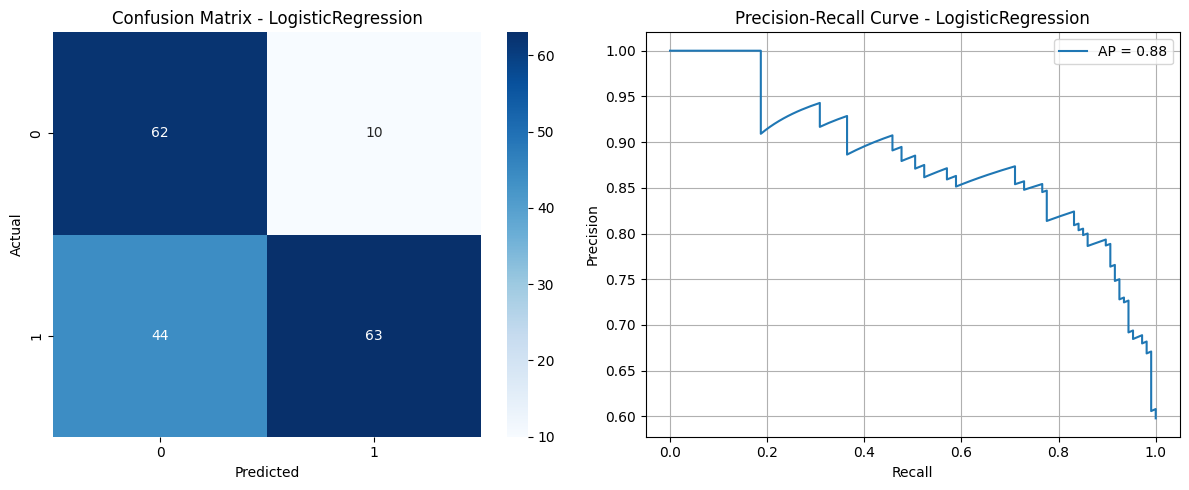

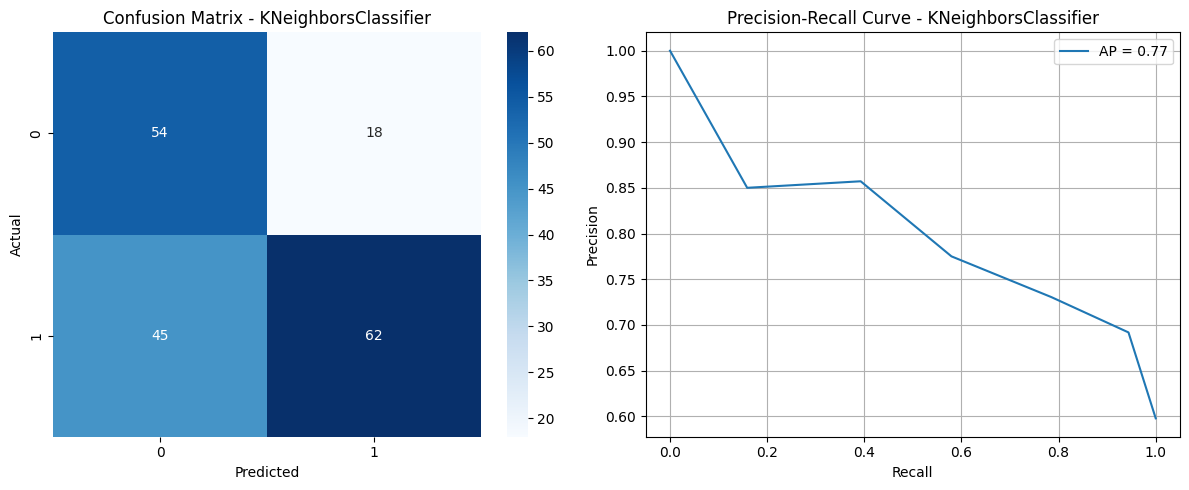

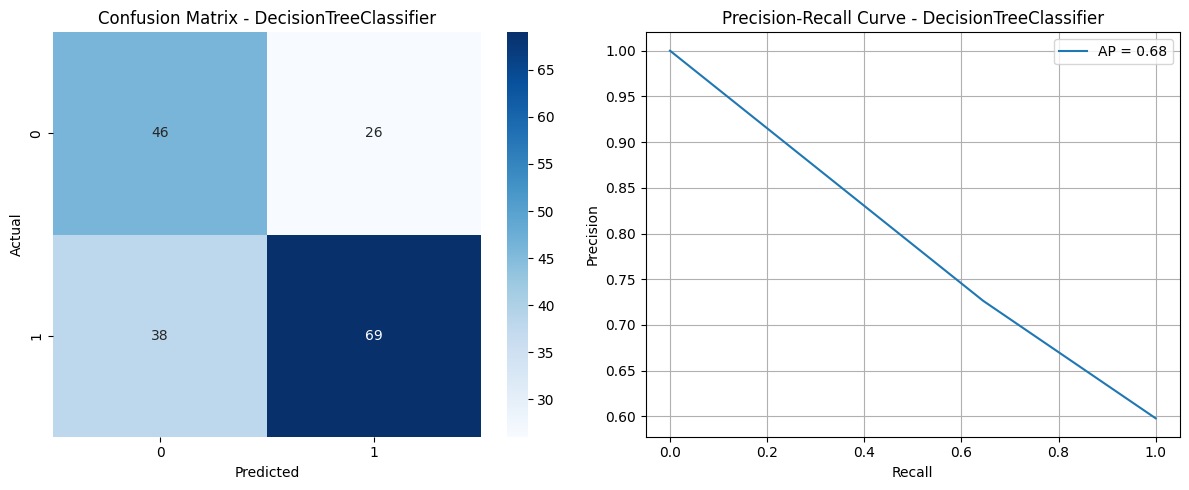

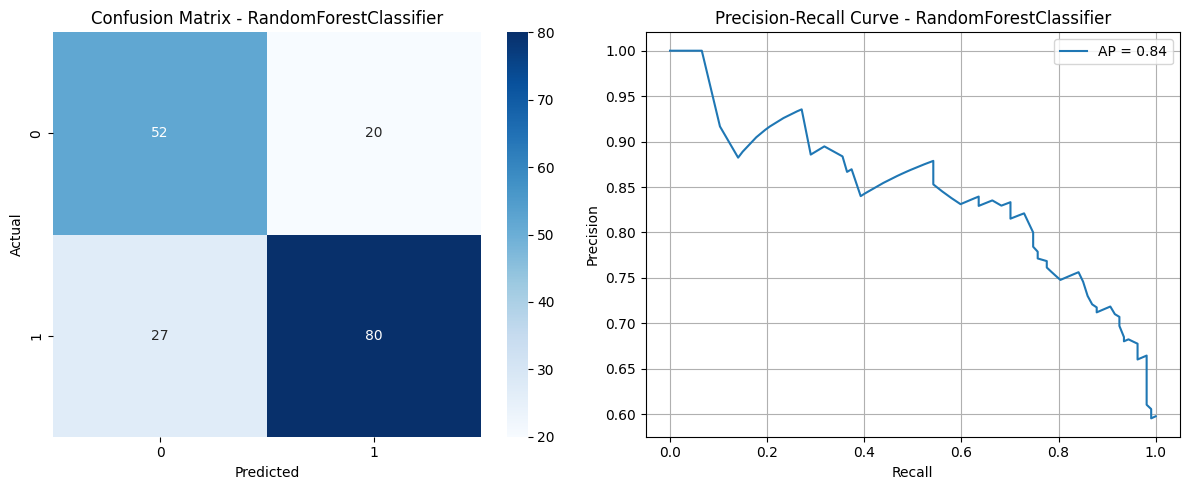

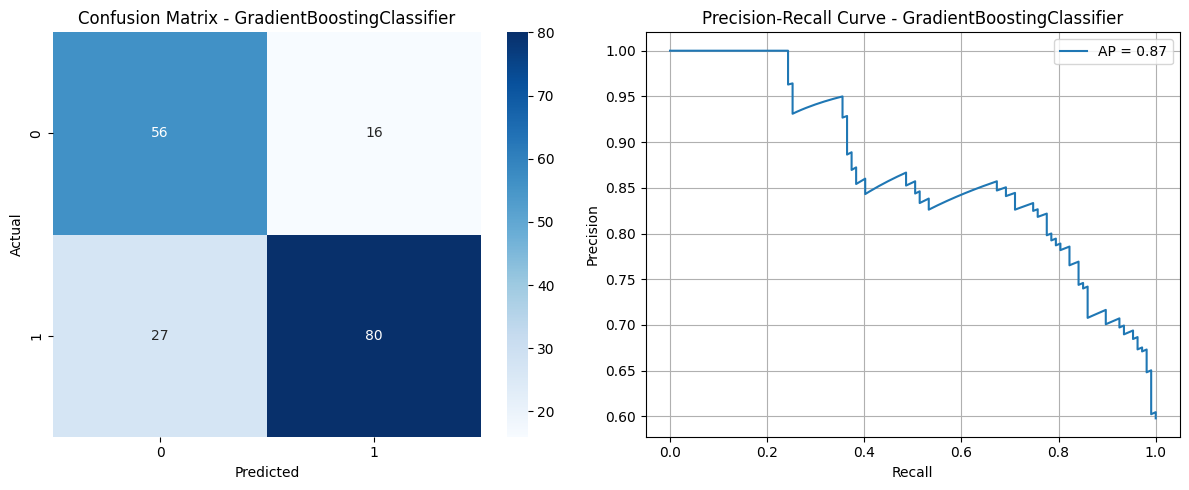

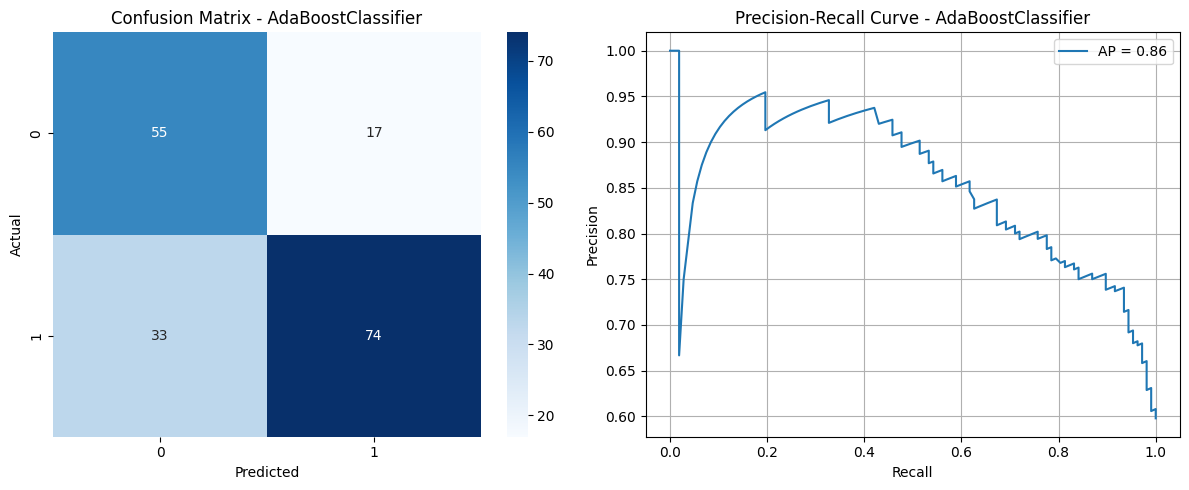

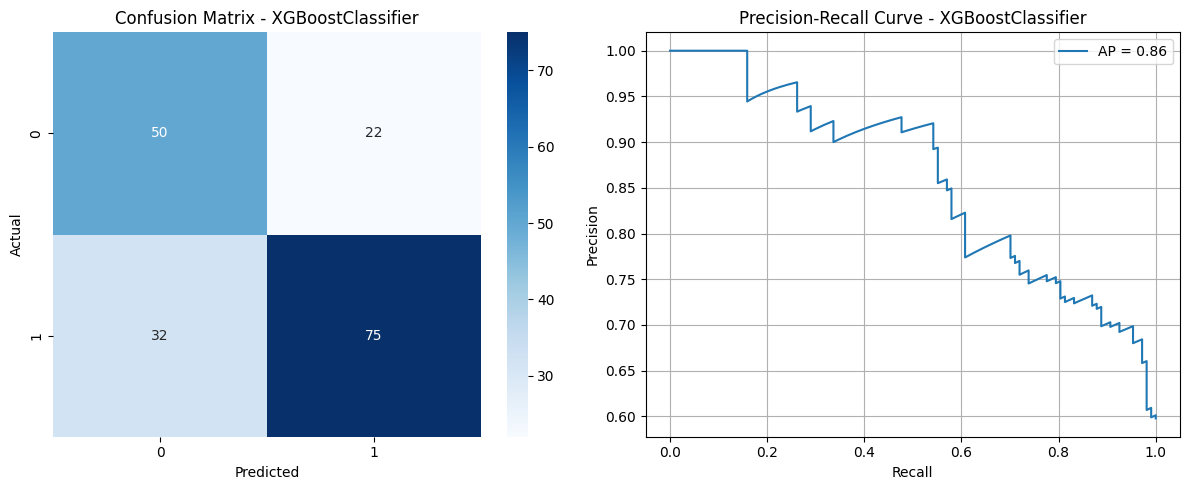

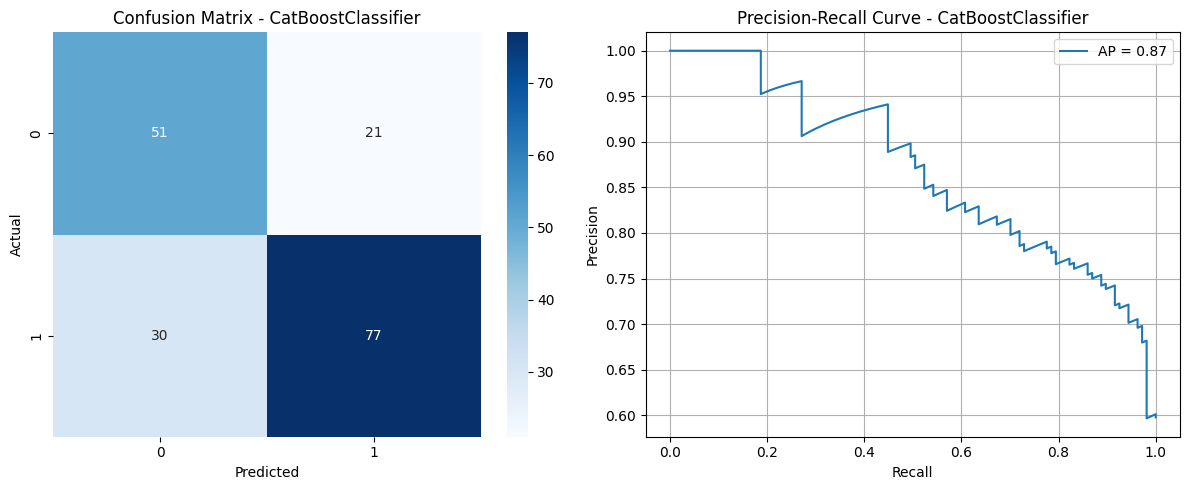

In [15]:
results_df = evaluate_models(X_train, y_train, X_test, y_test, models, ct)

Models listed by descending precision score on test set

In [16]:
results_df['test_precision'].sort_values(ascending=False)

model_name
LogisticRegression            0.863
GradientBoostingClassifier    0.833
AdaBoostClassifier            0.813
RandomForestClassifier        0.800
CatBoostClassifier            0.786
KNeighborsClassifier          0.775
XGBoostClassifier             0.773
DecisionTreeClassifier        0.726
Name: test_precision, dtype: float64

Models listed by descending fbeta score with beta=0.5. It means that precision has double of the weight than recall

In [40]:
results_df['test_f0.5'].sort_values(ascending=False)

model_name
GradientBoostingClassifier    0.815
LogisticRegression            0.789
RandomForestClassifier        0.789
AdaBoostClassifier            0.786
CatBoostClassifier            0.772
XGBoostClassifier             0.758
KNeighborsClassifier          0.726
DecisionTreeClassifier        0.708
Name: test_f0.5, dtype: float64

Models listed by descending average precision score. It shows an overall precision-recall balance at different thresholds

In [39]:
results_df['test_avg_precision'].sort_values(ascending=False)

model_name
LogisticRegression            0.882
CatBoostClassifier            0.869
GradientBoostingClassifier    0.868
XGBoostClassifier             0.859
AdaBoostClassifier            0.856
RandomForestClassifier        0.840
KNeighborsClassifier          0.774
DecisionTreeClassifier        0.681
Name: test_avg_precision, dtype: float64

#### Picking top 3 baseline models based on fbeta_score

In [70]:
top_3_base_models = results_df['test_f0.5'].sort_values(ascending=False).nlargest(3).index.values.tolist()

top_3_base_models

['GradientBoostingClassifier', 'LogisticRegression', 'RandomForestClassifier']

#### Plotting features importances for the top 3 models

In [78]:
sns.set_style('whitegrid')
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

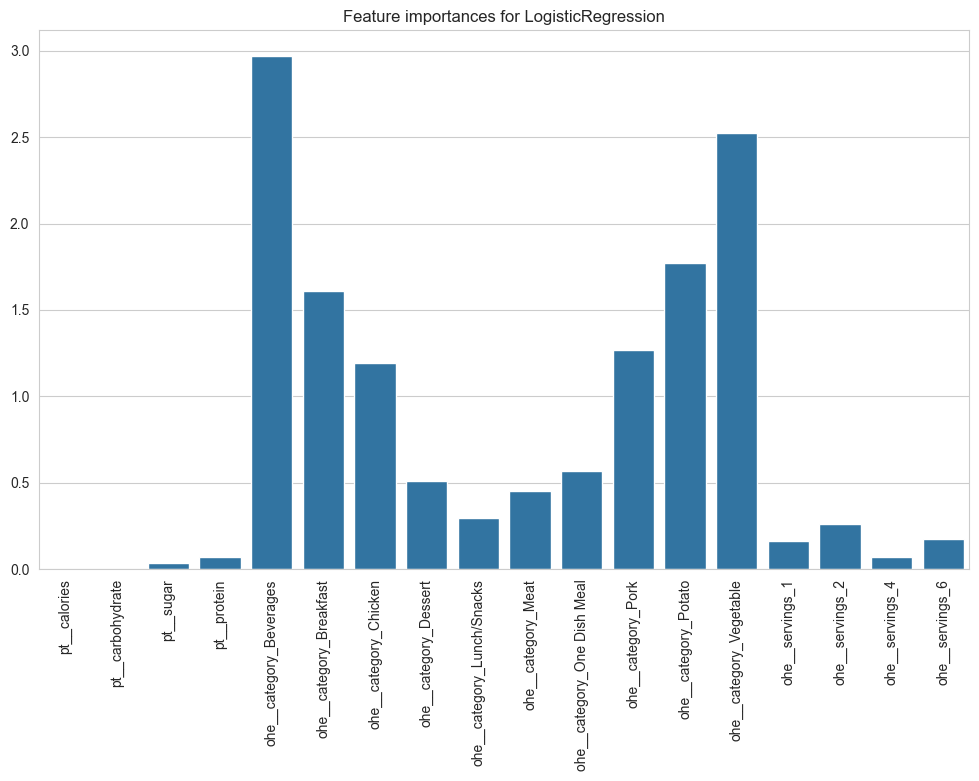

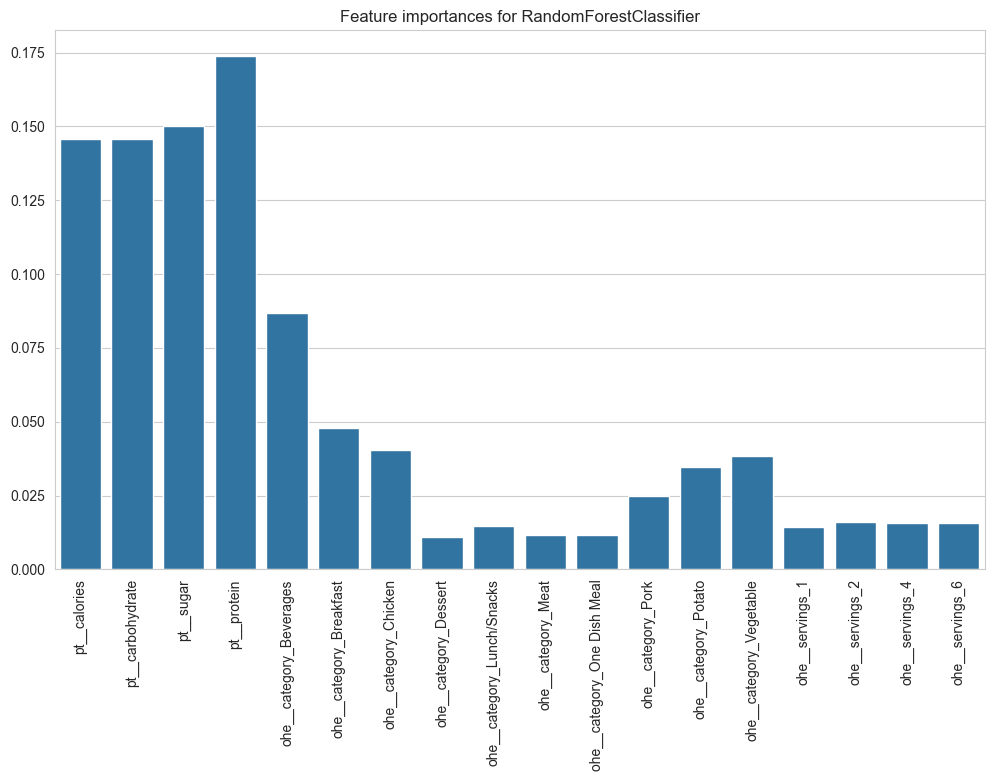

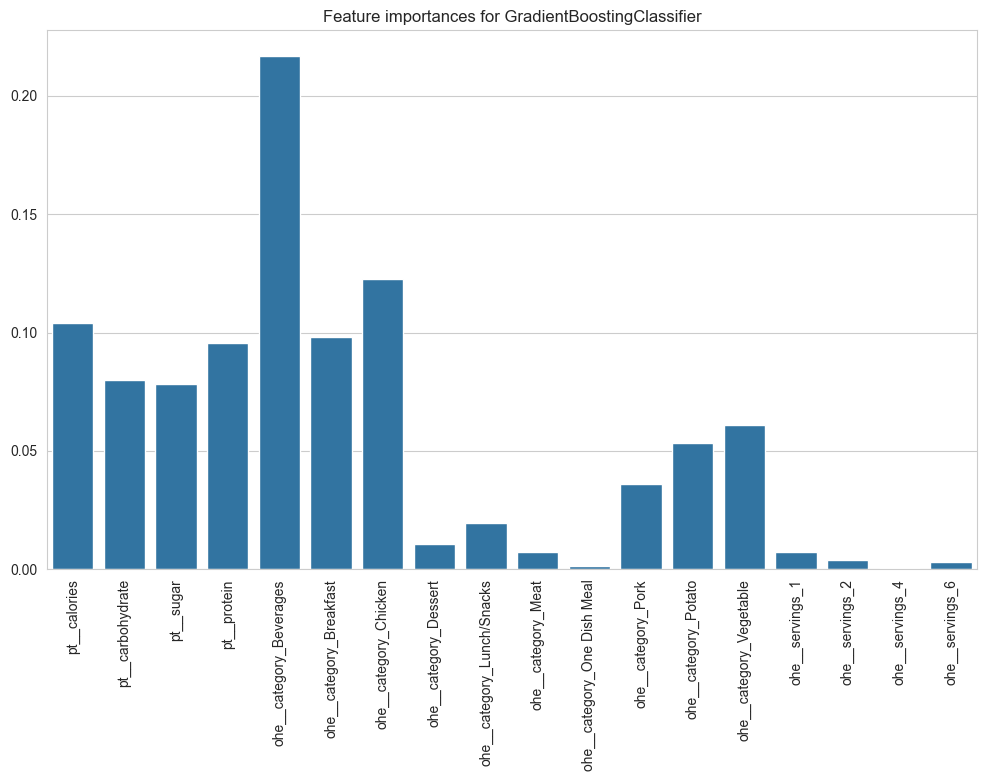

In [79]:
for model_name, model in models.items():
    
    if model_name in top_3_base_models:
    
        if model_name == 'LogisticRegression':

            pipe = ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
            pipe.fit(X_train, y_train)
            
            importances_series = pd.Series(abs(pipe.named_steps["model"].coef_[0]), index=pipe.named_steps['ct'].get_feature_names_out())
        else:
            pipe = Pipeline(steps=[("ct", ct),('model', model)])
            pipe.fit(X_train, y_train)
    
            importances_series = pd.Series(pipe.named_steps['model'].feature_importances_, index=pipe.named_steps['ct'].get_feature_names_out())
            
        fig, ax = plt.subplots(figsize=(12,7))
        sns.barplot(importances_series)
        plt.title(f"Feature importances for {model_name}")
        plt.xticks(rotation=90)
        plt.show()

Tree based models rely heavily on numerical features, while LogisticRegression relies on the category column.
The difference can be attributed to the fact that LogisticRegression captures linear relationships while tree based models capture non-linear relationships.

We have a small amount of features in the dataset but feature selection could be performed with minimal amount of performance loss

#### Setting up hyperparameters to try for the top 3 models

In [81]:
params = {
    "LogisticRegression": [
        {
            'model__penalty': ['l2'],
            'model__solver': ['lbfgs', 'liblinear'],
            'model__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
        },
        {
            'model__penalty': ['l1'],
            'model__solver': ['liblinear', 'saga'],
            'model__C': [0.001, 0.01, 0.1, 1.0, 10.0],
        },
        {
            'model__penalty': ['elasticnet'],
            'model__solver': ['saga'],
            'model__C': [0.01, 0.1, 1.0, 10.0],
            'model__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0]
        }
    ],

    "GradientBoostingClassifier": {
        'model__loss': ['log_loss'],
        'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0],
        'model__n_estimators': [50, 100, 150, 200],
        'model__max_depth': [3, 4, 5, 7],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None],
        'model__criterion': ['friedman_mse', 'squared_error']
    },

    "RandomForestClassifier": {
        'model__n_estimators': [50, 100, 150, 200],
        'model__max_depth': [None, 5, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': ['sqrt', 'log2', None],
        'model__bootstrap': [True, False],
        'model__class_weight': [None, 'balanced']
    }
}


#### The hyperparameter_tuning function finds the best hyperparameters to apply for the provided models

Creating fbeta_scorer as it is not built-in in GridSearchCV

In [82]:
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

In [84]:
def hyperparameter_tuning(X_train, y_train, X_test, y_test, models, top_models, column_transformer, scorer, params={}):
    report = []
    best_model_name = None
    best_model = None
    best_params = None
    best_score = 0
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for model_name, model in models.items():
        
        if model_name in top_3_base_models:
            param = params.get(model_name, {})
            
            with mlflow.start_run(run_name=model_name):
                if model_name in ['LogisticRegression', 'KNeighborsClassifier']:
                    
                    pipe_with_sampling = ImbPipeline(steps=[("ct", ct), ('smote', SMOTE(random_state=42)),('model', model)])
                    grid = GridSearchCV(pipe_with_sampling, param, cv=skf, n_jobs=-1, scoring=scorer)
                    
                else:
                    pipe = Pipeline(steps=[("ct", ct),('model', model)])
                    grid = GridSearchCV(pipe, param, cv=skf, n_jobs=-1, scoring=scorer)
                    
                grid.fit(X_train, y_train)
                
                
                y_train_pred = grid.best_estimator_.predict(X_train)
                y_test_pred = grid.best_estimator_.predict(X_test)
                y_train_probs = grid.best_estimator_.predict_proba(X_train)[:, 1]
                y_test_probs = grid.best_estimator_.predict_proba(X_test)[:, 1]
            
                
                        
                fig, ax = plt.subplots(1, 2, figsize=(12, 5))
                sns.heatmap(confusion_matrix(y_test, y_test_pred), fmt='d', annot=True, cmap='Blues', ax=ax[0])
                ax[0].set_title(f"Confusion Matrix - {model_name}")
                ax[0].set_xlabel("Predicted")
                ax[0].set_ylabel("Actual")

                precision, recall, _ = precision_recall_curve(y_test, y_test_probs)
                avg_prec = average_precision_score(y_test, y_test_probs)

                ax[1].plot(recall, precision, label=f"AP = {avg_prec:.2f}")
                ax[1].set_title(f"Precision-Recall Curve - {model_name}")
                ax[1].set_xlabel("Recall")
                ax[1].set_ylabel("Precision")
                ax[1].legend()
                ax[1].grid()

                plt.tight_layout()
                plt.show()
                
                
                train_metrics = get_scores(y_train, y_train_pred, y_train_probs, mode="train")
                test_metrics = get_scores(y_test, y_test_pred, y_test_probs, mode="test")
            
                log_metrics_in_mlflow(train_metrics)
                log_metrics_in_mlflow(test_metrics)
            
                mlflow.log_params(grid.best_params_)
                mlflow.set_tag("model description", f"{model_name} with tuned parameters")
            
                scores = {
                "model_name": model_name,
                **train_metrics,
                **test_metrics
                }
                
                scores = {
                    "model_name": model_name,
                    **train_metrics,
                    **test_metrics
                }
                
                if scores['test_f0.5'] > best_score:
                    best_score = scores['test_f0.5']
                    best_model_name = model_name
                    best_model = grid.best_estimator_
                    best_params = grid.best_params_
                    
                report.append(scores)
            
        else:
            next
        
    results_df = pd.DataFrame(report).set_index("model_name").round(3)
    print(f"Best model is: {best_model_name} with an f-beta (0.5) score of: {best_score:.3f}")
    
    return best_model_name, best_model, best_params, results_df

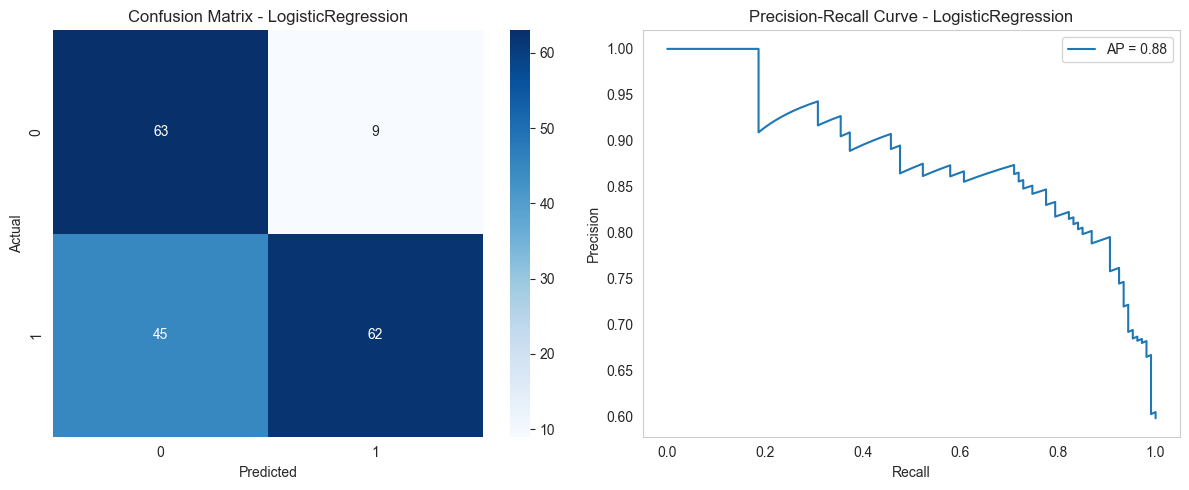

🏃 View run LogisticRegression at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/5b012f46b3b44cdf851637e1d366175e
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


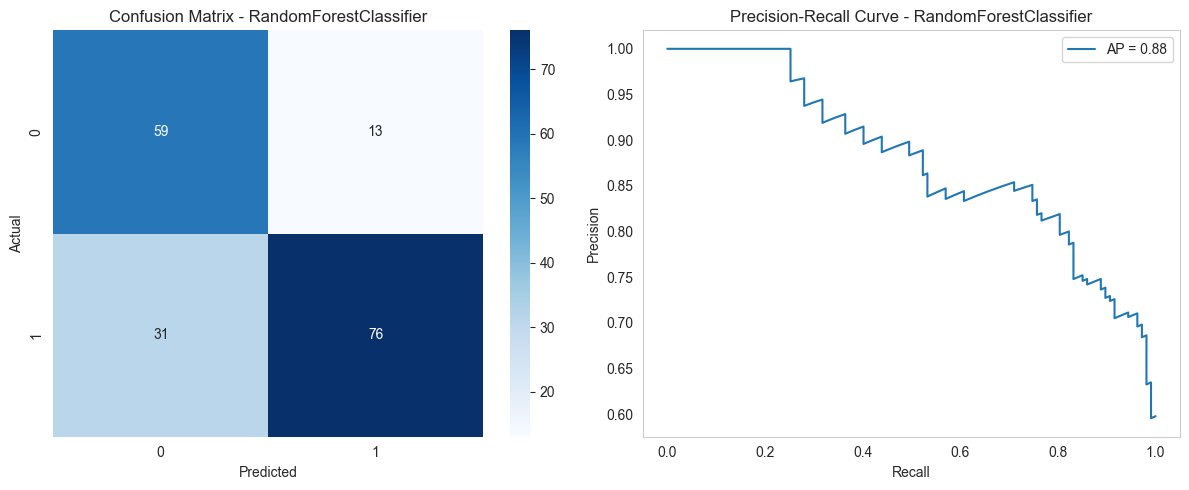

🏃 View run RandomForestClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/88df204e923b444e9ea1ee802b38744b
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0


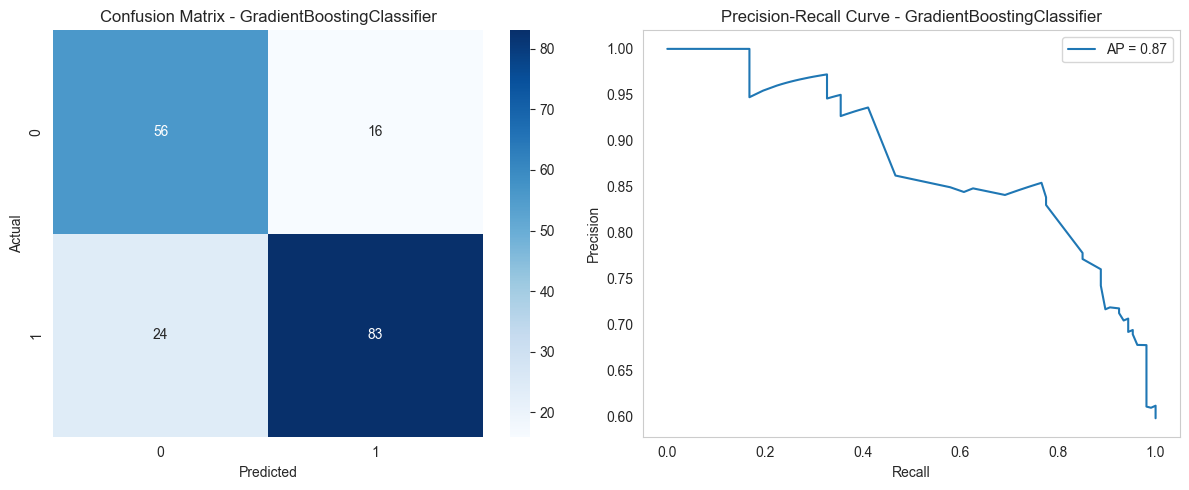

🏃 View run GradientBoostingClassifier at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0/runs/6585283489804e148a2b86b34a17bac3
🧪 View experiment at: https://dagshub.com/RichardHolzhofer/recipe_site_traffic_classification.mlflow/#/experiments/0
Best model is: GradientBoostingClassifier with an f-beta (0.5) score of: 0.825
Best model: GradientBoostingClassifier
Best params: {'model__criterion': 'friedman_mse', 'model__learning_rate': 0.05, 'model__loss': 'log_loss', 'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2, 'model__n_estimators': 50, 'model__subsample': 1.0}


In [86]:
best_model_name, best_model, best_params, results_df = hyperparameter_tuning(X_train, y_train, X_test, y_test, models, top_3_base_models, ct, fbeta_scorer, params)

print(f"Best model: {best_model_name}")
print(f"Best params: {best_params}")

### Taking a look at the results

- All models performed quite well.
- The model with the best precision is LogisticRegression
- The model with the best fbeta score (beta=0.5) is GradientBoostingClassifier

In [93]:
results_df[['test_f0.5', 'test_precision']].sort_values(by='test_f0.5', ascending=False)

,test_f0.5,test_precision
model_name,,
GradientBoostingClassifier,0.825,0.838
RandomForestClassifier,0.821,0.854
LogisticRegression,0.793,0.873


# Conclusion

Since the performances were already quite close to each other on the baseline models, I focused on the fbeta_score metric which doesn't let the model to predict all recipes to 'High' because it balances the result with recall. The final model, GradientBoostingClassifier is more robust to outliers and has still good interpretability. Because of the low number of records we can pick this model to the detriment of training time, over LogisticRegression and RandomForestClassifier.

### Saving the model

In [96]:
dir_path = os.path.join(os.getcwd(),'models')

os.makedirs(dir_path)

joblib.dump(best_model,os.path.join(dir_path,"best_model.joblib"))

print(f"Best model saved to: {dir_path}")

Best model saved to: d:\my_portfolio\recipe_site_traffic_classification\notebooks\models
